## Image Classification using Deep Convolutional Neural Networks and Transfer Learning

the dataset used comes from 6 types of plastic. The dataset can be accessed via the following link: https://drive.google.com/drive/folders/1BFPXGbwT6l42WjN9kSHeKbvOO4kjEWlo?usp=sharing

### Import Necessary Libraries

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
# System libraries
from pathlib import Path
import os.path

In [4]:
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

### Create helper functions

In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-06-16 14:26:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py.6'

     0K ..........                                            100%  426K=0,02s

2023-06-16 14:27:01 (426 KB/s) - 'helper_functions.py.6' saved [10246/10246]



### Load and transform data

In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

In [7]:
# Walk through each directory
dataset = "D:\Dataset\Dipakek"
walk_through_dir(dataset)

There are 6 directories and 0 images in 'D:\Dataset\Dipakek'.
There are 0 directories and 797 images in 'D:\Dataset\Dipakek\Botol'.
There are 0 directories and 768 images in 'D:\Dataset\Dipakek\Ember'.
There are 0 directories and 763 images in 'D:\Dataset\Dipakek\Gelas'.
There are 0 directories and 758 images in 'D:\Dataset\Dipakek\Jerigen'.
There are 0 directories and 776 images in 'D:\Dataset\Dipakek\Karung'.
There are 0 directories and 768 images in 'D:\Dataset\Dipakek\Kresek'.


#### Placing data into a Dataframe
The first column filepaths contains the file path location of each individual images. The second column labels, on the other hand, contains the class label of the corresponding image from the file path

In [8]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [9]:
print(labels)

0        Botol
1        Botol
2        Botol
3        Botol
4        Botol
         ...  
4625    Kresek
4626    Kresek
4627    Kresek
4628    Kresek
4629    Kresek
Name: Label, Length: 4630, dtype: object


In [10]:
image_df

,Filepath,Label
0,D:\Dataset\Dipakek\Botol\00004254.png,Botol
1,D:\Dataset\Dipakek\Botol\00004255.png,Botol
2,D:\Dataset\Dipakek\Botol\00004256.png,Botol
3,D:\Dataset\Dipakek\Botol\00004257.png,Botol
4,D:\Dataset\Dipakek\Botol\00004258.png,Botol
...,...,...
4625,D:\Dataset\Dipakek\Kresek\ttobcfc3mgmpord9inan...,Kresek
4626,D:\Dataset\Dipakek\Kresek\ttobcfc3mgmpord9inan...,Kresek
4627,D:\Dataset\Dipakek\Kresek\w3atsiiy7q01jirlxjvy...,Kresek
4628,D:\Dataset\Dipakek\Kresek\WAsr05MGai43.png,Kresek


### Visualizing images from the dataset

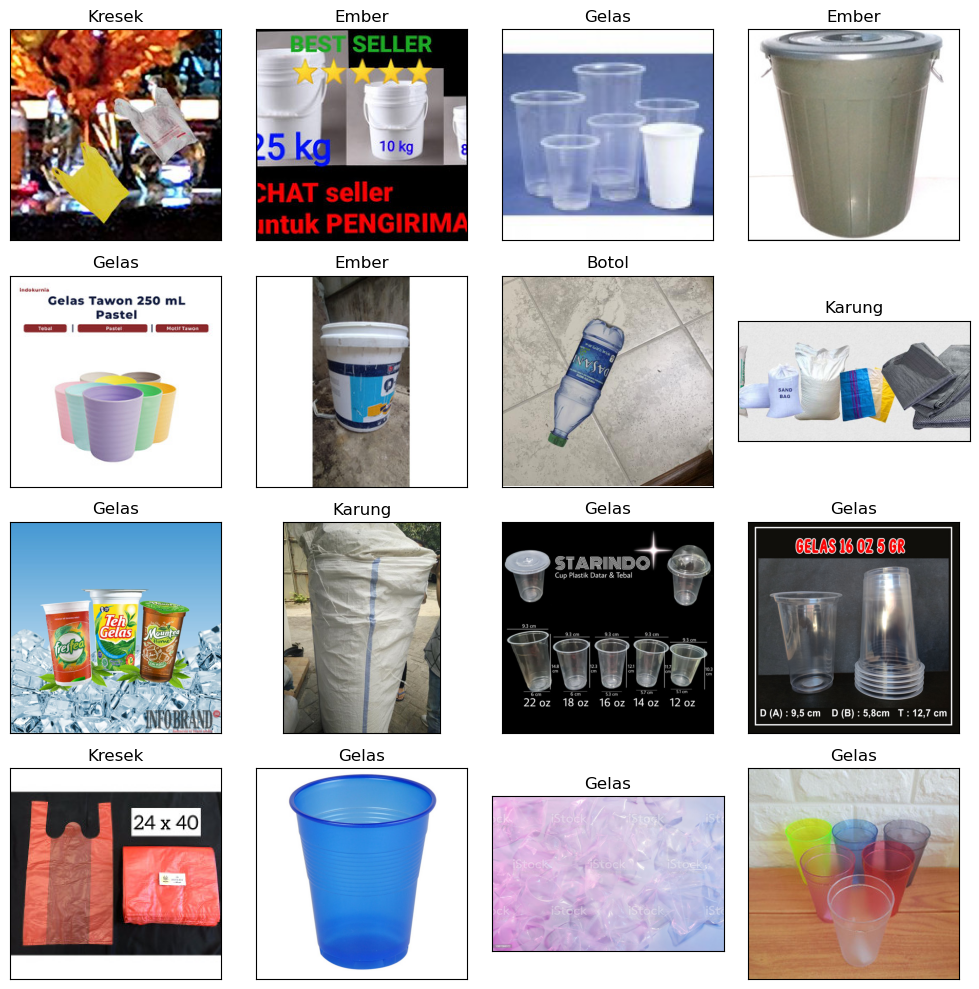

In [11]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

### Data Preprocessing
The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).

In [12]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [13]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [14]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2964 validated image filenames belonging to 6 classes.
Found 740 validated image filenames belonging to 6 classes.
Found 926 validated image filenames belonging to 6 classes.


In [15]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Training the model
The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:

#### Batch size : 32
#### Epochs : 100
#### Input Shape : (224, 224, 3)
#### Output layer : 2

In [16]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [17]:
# Create checkpoint callback
checkpoint_path = "bottles_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [18]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

### Training the model

In [19]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)



outputs = Dense(6, activation='softmax')(x)  # Adjust to the correct number of classes


model = Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "bottle_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/bottle_classification/20230616-142713
Epoch 1/100
16/93 [====>.........................] - ETA: 2:07 - loss: 1.7451 - accuracy: 0.2930

C:\Users\Asus\anaconda3\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


93/93 [==============================] - 214s 2s/step - loss: 1.0307 - accuracy: 0.6454 - val_loss: 0.3570 - val_accuracy: 0.9176
Epoch 2/100
93/93 [==============================] - 151s 2s/step - loss: 0.3449 - accuracy: 0.8937 - val_loss: 0.1946 - val_accuracy: 0.9432
Epoch 3/100
93/93 [==============================] - 125s 1s/step - loss: 0.2227 - accuracy: 0.9315 - val_loss: 0.1468 - val_accuracy: 0.9581
Epoch 4/100
93/93 [==============================] - 133s 1s/step - loss: 0.1738 - accuracy: 0.9467 - val_loss: 0.1254 - val_accuracy: 0.9649
Epoch 5/100
93/93 [==============================] - 129s 1s/step - loss: 0.1386 - accuracy: 0.9541 - val_loss: 0.1077 - val_accuracy: 0.9716
Epoch 6/100
93/93 [==============================] - 131s 1s/step - loss: 0.1071 - accuracy: 0.9679 - val_loss: 0.1035 - val_accuracy: 0.9662
Epoch 7/100
93/93 [==============================] - 131s 1s/step - loss: 0.0861 - accuracy: 0.9727 - val_loss: 0.1039 - val_accuracy: 0.9703
Epoch 8/100
93/93 

### Summary Model

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

### Model Evaluation
The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows: Precision(P), Recall(R), and F1 score(F1)

In [21]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.12447
Test Accuracy: 95.36%


### Visualizing loss curves

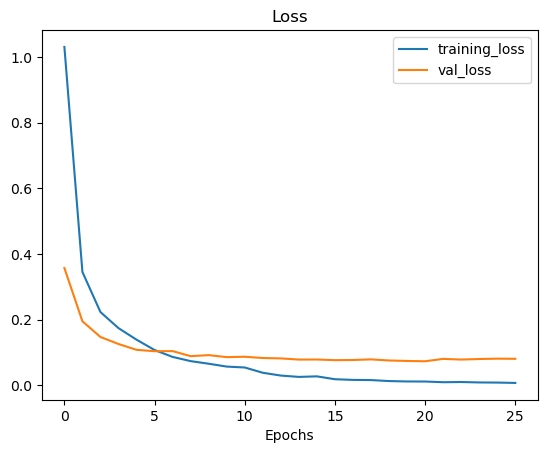

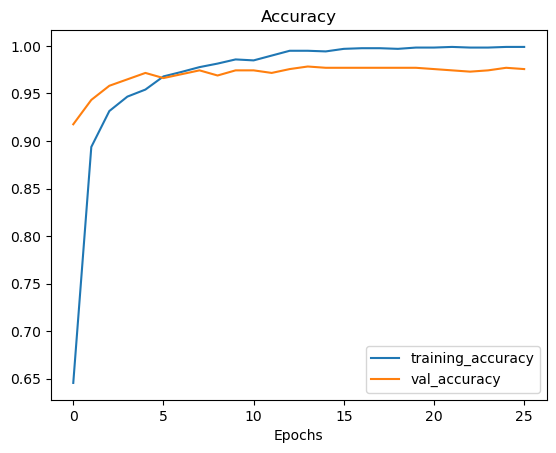

In [22]:
plot_loss_curves(history)

### Making predictions on the test data 

In [23]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

29/29 [==============================] - 24s 791ms/step
The first 5 predictions: ['Ember', 'Jerigen', 'Kresek', 'Karung', 'Botol']


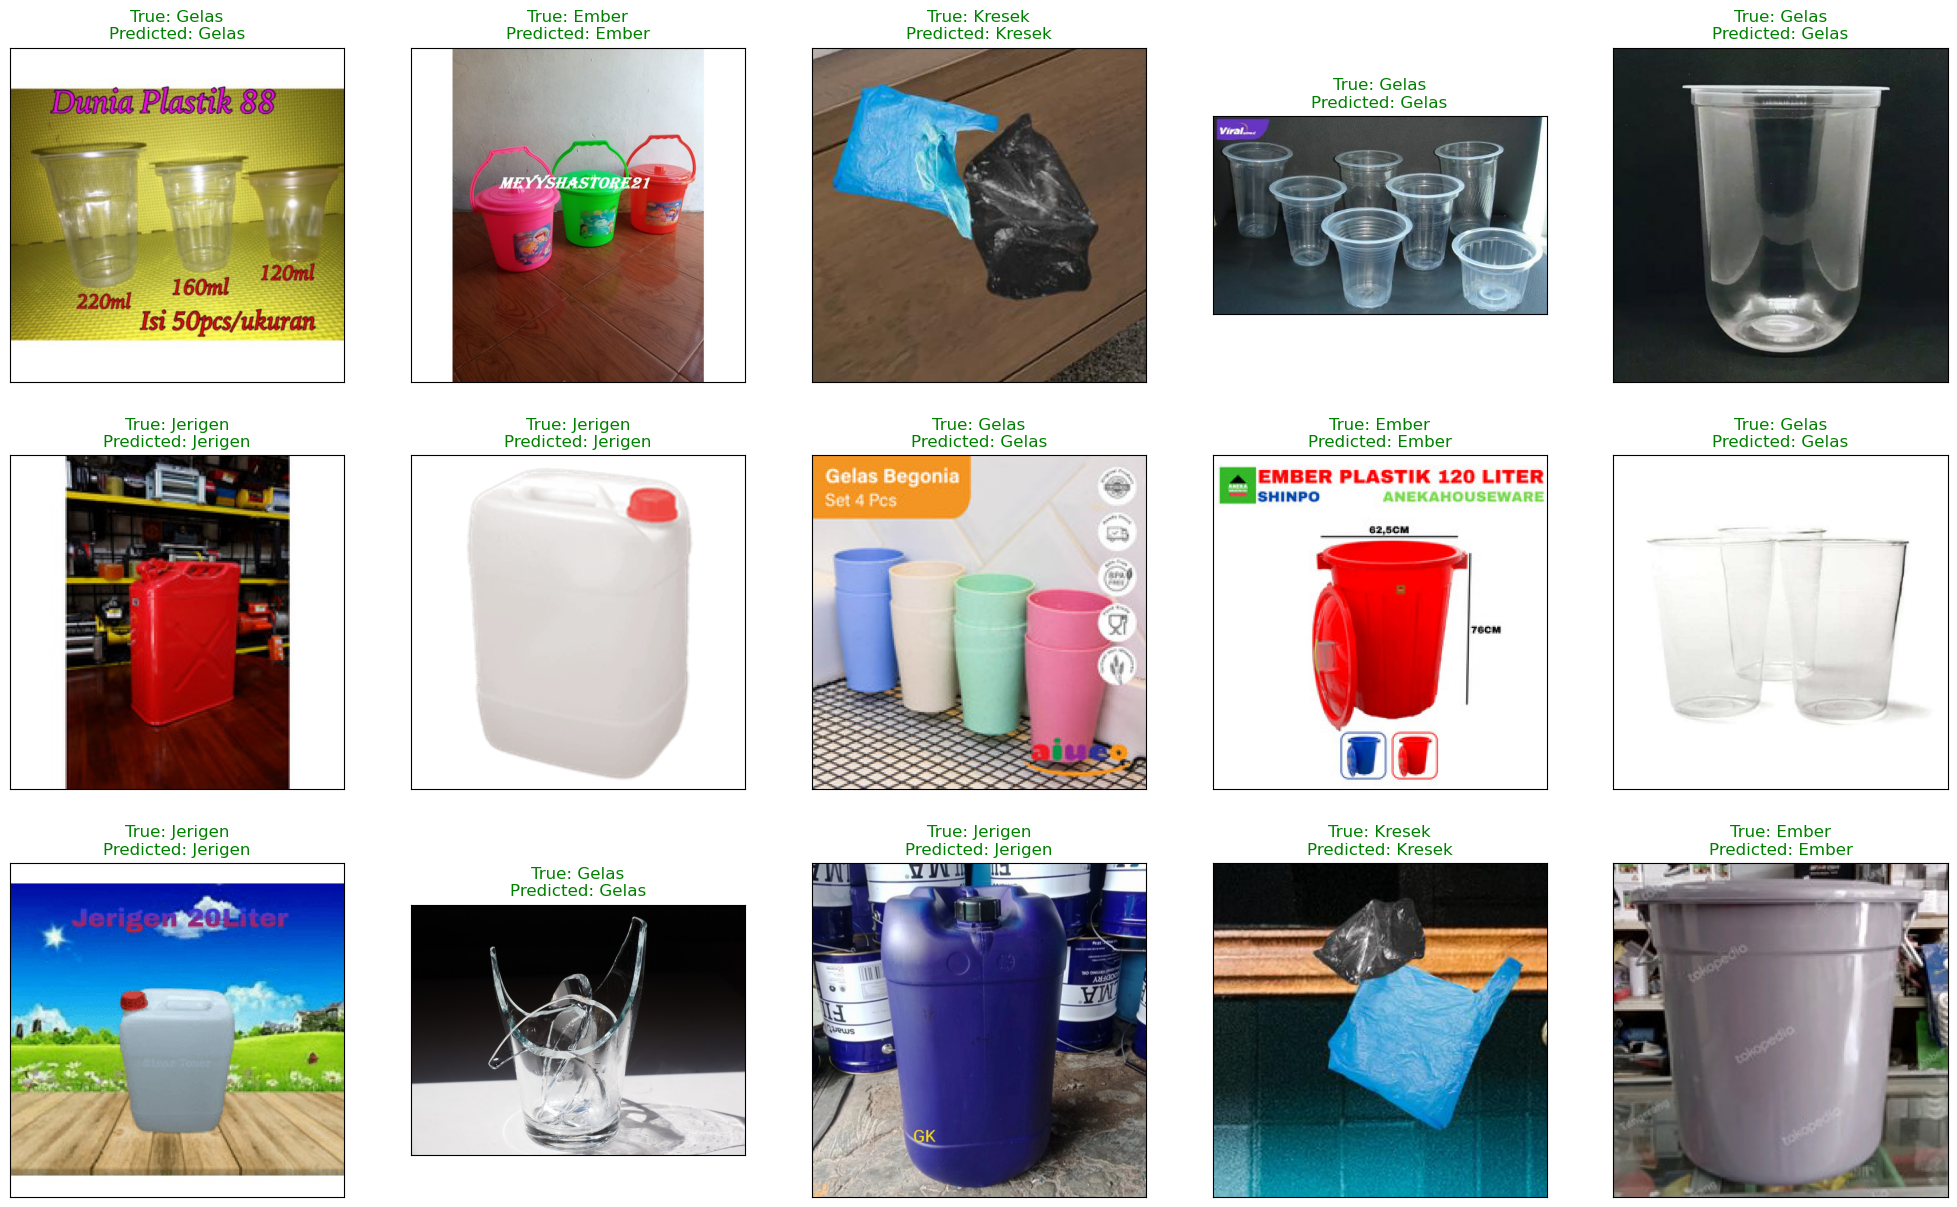

<Figure size 640x480 with 0 Axes>

In [24]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

### Plotting the classification reports and confusion matrix

In [25]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       Botol       0.96      0.94      0.95       176
       Ember       0.97      0.96      0.97       163
       Gelas       0.90      0.92      0.91       134
     Jerigen       0.99      0.99      0.99       157
      Karung       0.95      0.91      0.93       146
      Kresek       0.94      1.00      0.97       150

    accuracy                           0.95       926
   macro avg       0.95      0.95      0.95       926
weighted avg       0.95      0.95      0.95       926



In [26]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
Botol,0.959302,0.937500,0.948276,176.000000
Ember,0.969136,0.963190,0.966154,163.000000
Gelas,0.904412,0.917910,0.911111,134.000000
Jerigen,0.987261,0.987261,0.987261,157.000000
Karung,0.950000,0.910959,0.930070,146.000000
Kresek,0.943396,1.000000,0.970874,150.000000
accuracy,0.953564,0.953564,0.953564,0.953564
macro avg,0.952251,0.952803,0.952291,926.000000
weighted avg,0.953787,0.953564,0.953445,926.000000


In [27]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=90, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

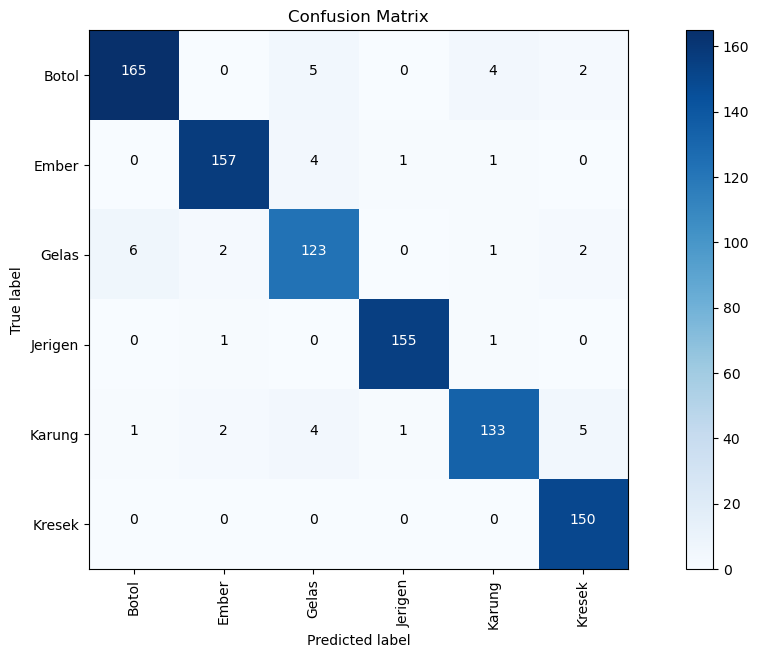

In [28]:
make_confusion_matrix(y_test, pred, list(labels.values()))

### Make a prediciton from local file

In [53]:
#Predict by file location
from tensorflow.keras.preprocessing import image
img_path = "C:/Users/Asus/Downloads/sejarah-plastik.jpg"
img = image.load_img(img_path, target_size=(224, 224))  # Adjust the target size as per your model's input size
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # Normalize the pixel values (if required)

In [33]:
preds = model.predict(x)

1/1 [==============================] - 1s 788ms/step


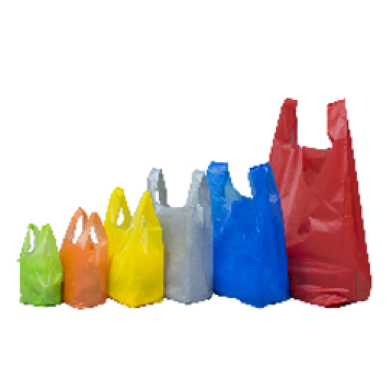

Predicted class: Kresek


In [54]:
predicted_class = np.argmax(preds, axis=1)

# Load the class labels
class_labels = ['Botol','Ember','Gelas','Jerigen','Karung','Kresek']  # Replace with your actual class labels

# Get the predicted class label
predicted_label = class_labels[predicted_class[0]]

#Show image
img = img.resize((256, 256))
plt.imshow(img)
plt.axis('off')
plt.show()

# Print the predicted class label or perform further processing
print("Predicted class:", predicted_label)
